# Project: Measuring Causal Relations with Python

## Task 1: Import Libraries 

In [13]:
# math and stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# graphs 
import graphviz
import networkx as nx 

# causality
from dowhy import CausalModel
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# other tools
import pandas as pd
from IPython.display import display_png
import pprint

## Task 2: Load the Dataset

In [14]:
# Load the dataset
data = pd.read_csv("/workspaces/causal-relations/data.csv")
# Print the first five frows of the dataset
data.head()

,treat,age,hisp,black,married,educ,nodegr,re19,re20,re22
0,1,29,0,0,1,13.0,0,28221,28072,44686
1,0,48,0,1,0,8.0,1,38135,38674,43367
2,1,21,0,0,1,9.0,0,27193,27913,41550
3,0,50,0,0,0,12.0,1,41695,42696,38669
4,1,49,1,0,0,10.8,0,25159,24935,47043


## Task 3: Explore the Dataset

treat      0
age        0
hisp       0
black      0
married    0
educ       0
nodegr     0
re19       0
re20       0
re22       0
dtype: int64


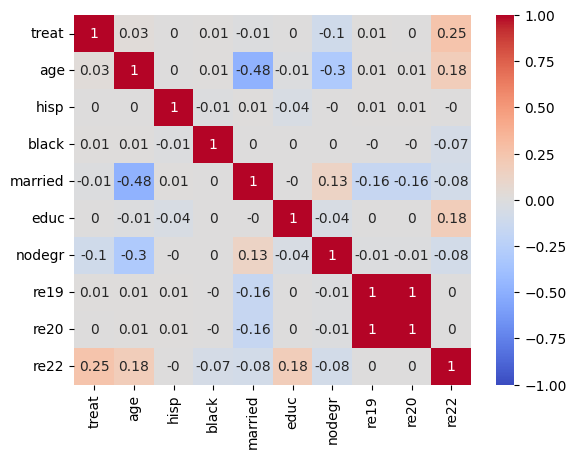

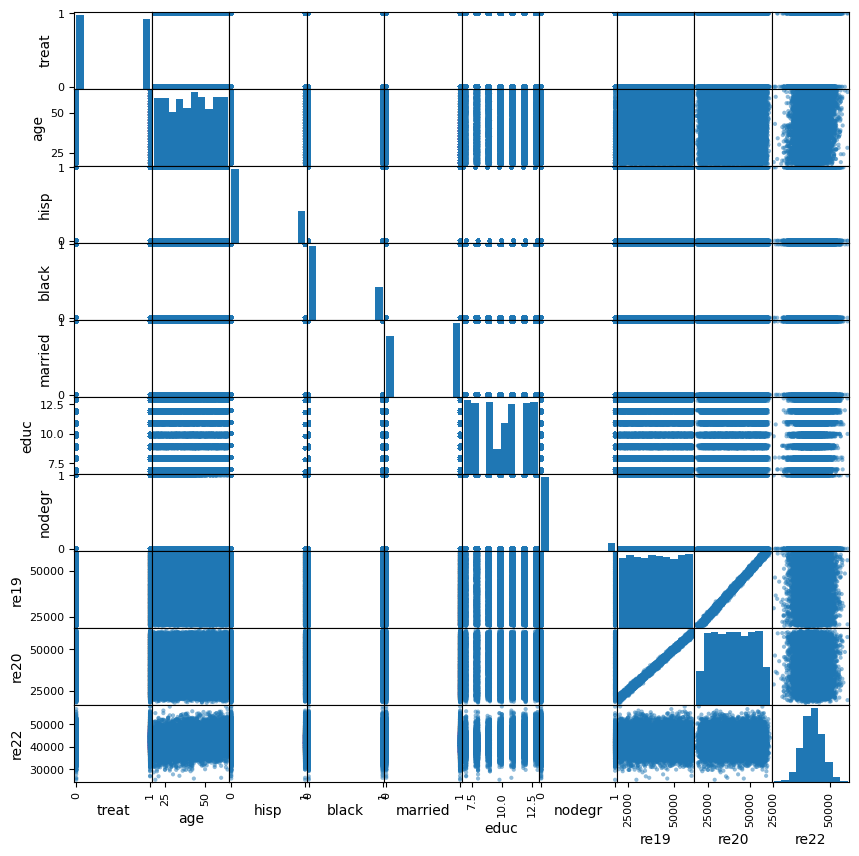

In [15]:
# Check for the missing values 
print(data.isna().sum())
# Print a convise summary of the DataFrame
data.describe()
# Create a correlation matrix
correlation_matrix = data.corr().round(2)
# Plot a heatmap to visualize the correlation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()
# Plot the scatter matrix
pd.plotting.scatter_matrix(data, figsize=(10, 10))
plt.show()

## Task 4: Build Causal Graphical Models using DAGs

`list(data)`: This assumes data is an iterable (like a list, tuple, or dictionary). If data is a dictionary, `list(data)` will give you a list of its keys.

`range(len(list(data)))`: This generates a sequence of numbers from 0 to `len(list(data)) - 1`. Essentially, it creates a list of indices corresponding to the elements in data.

`zip(range(len(list(data))), list(data))`: This pairs each index with the corresponding element (or key) from data.

Dictionary Comprehension: `{k: v for k, v in zip(...)}` creates a dictionary where each index from the range is mapped to the corresponding element (or key) from data.

In [16]:
# Create a dictionary that maps numbers to the names of variables and its inverse
mapping = {k: v for k, v in zip(range(len(list(data))), list(data))}
invserse_mapping = {v: k for k, v in mapping.items()}

pprint.pprint(mapping)
print('----------------')
pprint.pprint(invserse_mapping)


{0: 'treat',
 1: 'age',
 2: 'hisp',
 3: 'black',
 4: 'married',
 5: 'educ',
 6: 'nodegr',
 7: 're19',
 8: 're20',
 9: 're22'}
----------------
{'age': 1,
 'black': 3,
 'educ': 5,
 'hisp': 2,
 'married': 4,
 'nodegr': 6,
 're19': 7,
 're20': 8,
 're22': 9,
 'treat': 0}


In [17]:
# Create a dictionary that maps numbers to the names of variables and its inverse
mapping = {k: v for k, v in zip(range(len(list(data))), list(data))}
inverse_mapping = {v: k for k, v in mapping.items()}

# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(len(list(data)))
required_edges = [
    ('educ', 're22'),
    ('age', 're22'),
    ('nodegr', 're22')
    ]
#Convert edges from variable names to indices using inverse_mapping.
required_edges=[(inverse_mapping[edge[0]], inverse_mapping[edge[1]]) for edge in required_edges]
forbidden_edges = [
    ('treat', 're19'),
    ('treat', 're20'),
    ('black', 'hisp'),
    ('black', 'age'),
    ('age', 'black'),
    ('hisp', 'black'),
    ('educ', 'black'),
    ('educ', 'hisp'),
    ('re22', 're19'),
    ('re22', 're20'),
    ('re20', 're19'),
    ('treat', 'nodegr')
    ]
forbidden_edges=[(inverse_mapping[edge[0]], inverse_mapping[edge[1]]) for edge in forbidden_edges]

priori_knowledge.add_required_edges(required_edges)
priori_knowledge.add_forbidden_edges(forbidden_edges)

# Learn the causal graph using the PC algorithm
pc = PC(priori_knowledge=priori_knowledge)
pc.learn(data)

# Get the predicted causal matrix and convert it to a directed graph
pred_dag = pc.causal_matrix
g_pred = nx.DiGraph(pred_dag)
g_pred = nx.relabel_nodes(g_pred, mapping, copy=True)